In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from PIL import Image

import time
import os

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

## HYPER PARAMS

In [3]:
test_number = "Test1"

dataroot = '../my_datasets/facades/'
saveroot = '../GAN_Images/'

image_size = 256

batch_size = 8
workers = 1

nz = 150
nc = 3
ngf = 6
ndf = 6

lr = 0.0001
beta = (0.5, 0.999)

num_epochs = 11
num_steps = 1
k = 1

## DATASET

In [4]:
train_dir = os.path.join(dataroot, 'train')
val_dir = os.path.join(dataroot, 'val')
test_dir = os.path.join(dataroot, 'test')

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((268,268)),
    torchvision.transforms.RandomCrop(image_size),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.Lambda(lambda img: (np.array(img) / 127.5) - 1),
    torchvision.transforms.ToTensor(),
])

In [6]:
class FacadesDataset(object):
    def __init__(self, root, transforms, category):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))
        self.category=category

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))
        
        # split image to source and target
        h, w, d = img.shape
        w = w // 2
        
        if self.category == 0:
          input_image = img[:, w:, :]

          # apply preprocessing transforms
          if self.transforms is not None:
              input_image = self.transforms(
                  Image.fromarray(input_image)
              )
          
          return input_image
        else:
          real_image = img[:, :w, :]

          # apply preprocessing transforms
          if self.transforms is not None:
              real_image = self.transforms(
                  Image.fromarray(real_image)
              )
          
          return real_image

    def __len__(self):
        return len(self.imgs)

In [7]:
train_set_x = FacadesDataset(
    root=train_dir, transforms=transforms, category=0
)
train_set_y = FacadesDataset(
    root=train_dir, transforms=transforms, category=1
)

train_loader_x = torch.utils.data.DataLoader(
    dataset=train_set_x,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

train_loader_y = torch.utils.data.DataLoader(
    dataset=train_set_y,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [8]:
print("Training Set:",len(train_set_x), len(train_set_y))

for xb in train_loader_x:
    xb = xb.to(device)
    print(xb.shape, xb.min(), xb.max())
    break
for xb in train_loader_x:
    xb = xb.to(device)
    print(xb.shape, xb.min(), xb.max())
    break

Training Set: 400 400
torch.Size([8, 3, 256, 256]) tensor(-1., device='cuda:0', dtype=torch.float64) tensor(1., device='cuda:0', dtype=torch.float64)
torch.Size([8, 3, 256, 256]) tensor(-1., device='cuda:0', dtype=torch.float64) tensor(1., device='cuda:0', dtype=torch.float64)


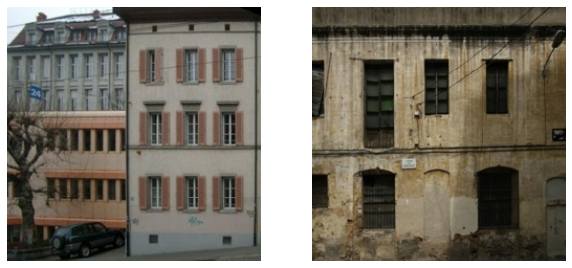

In [9]:
# load a batch
imgs = next(iter(train_loader_y))


# visualize batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 9))

ax1.axis("off")
ax2.axis("off")

ax1.imshow(np.transpose((imgs[0]+1)/2, (1, 2, 0)))
ax2.imshow(np.transpose((imgs[1]+1)/2, (1, 2, 0)));

## DOWNSAMPLE BLOCK

In [10]:
# Downsample Block
def ConvBlock(in_filters, out_filters, kernel, batch_norm, padding):
    if batch_norm:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )
    else:    
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_sizez=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [11]:
# Upsample Block
def ConvTransBlock(in_filters, out_filters, kernel, dropout, padding):
    if dropout:
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.Dropout2d(0.5),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )

## MODEL

In [12]:
# Generator Class
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.unet_down = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            ConvBlock(256, 512, 4, True, 1), # (bs, 16, 16, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 8, 8, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 4, 4, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 2, 2, 512)
            ConvBlock(512, 512, 4, True, 1) # (bs, 1, 1, 512)
        )
        
        self.unet_up = torch.nn.Sequential(
            ConvTransBlock(512, 512, 4, True, 1), # (bs, 2, 2, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 4, 4, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 8, 8, 1024)
            ConvTransBlock(1024, 512, 4, False, 13), # (bs, 16, 16, 1024)
            ConvTransBlock(1024, 256, 4, False, 25), # (bs, 32, 32, 512)
            ConvTransBlock(512, 128, 4, False, 49), # (bs, 64, 64, 256)
            ConvTransBlock(256, 64, 4, False, 97) # (bs, 128, 128, 128)
        )
        
        self.last = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=3,
                kernel_size=2,
                stride=2,
                padding=0,
                bias=False
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, inputs):
        
        skips = []
        for layer in self.unet_down:
            outputs = layer(inputs)
            skips.append(outputs)
            inputs = outputs
        
        rev_skips = reversed(skips[:-1])  # notice down has one more layer than up path
        
        for layer, skip in zip(self.unet_up, rev_skips):
            outputs = layer(inputs)  # first layer in upward takes the output from down directly w/o concat
            inputs = torch.cat(
                (outputs, skip), 1
            )
        
        return self.last(inputs)
            

In [13]:
# Discriminator Class ( Patch GAN )
# Every 70x70x3 patch is represented by a 30x30x1 output 

class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.net = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1),  # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1),  # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1),  # (bs, 32, 32, 256)
            torch.nn.ZeroPad2d(padding=1),  # (bs, 34, 34, 256)
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 31, 31, 512)
            torch.nn.BatchNorm2d(
                num_features=512
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ZeroPad2d(padding=1),  # (bs, 33, 33, 512)
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                bias=False
            ),  # (bs, 30, 30, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, inputs):
        return self.net(inputs)

In [14]:
netDX = Discriminator().to(device)
netDY = Discriminator().to(device)

netG = Generator().to(device)
netF = Generator().to(device)

In [15]:
# Optimizers
optimizerDX = torch.optim.Adam(
    netDX.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerDY = torch.optim.Adam(
    netDY.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerF = torch.optim.Adam(
    netF.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

In [16]:
# Objective Function ( Loss Function )

Lambda = 10  # according to paper authors
bce_loss = torch.nn.BCELoss()
mae_loss = torch.nn.L1Loss()

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels = torch.zeros(batch_size, 1, 30, 30).to(device)

## TRAIN

In [17]:
# Train Discriminator

def trainD(x, y):

    x = x.to(device).float()
    y = y.to(device).float()

    G_x = netG(x)  # equivalent to getting y back
    F_y = netF(y)  # equivalent to getting x back

    optimizerDX.zero_grad()
    optimizerDY.zero_grad()

    # Discriminator X
    real_outputs = netDX(x)
    fake_outputs = netDX(F_y)

    d_x_1 = bce_loss(real_outputs, real_labels)
    d_g_z_1 = bce_loss(fake_outputs, fake_labels)
    
    # Discriminator Y
    real_outputs = netDY(y)
    fake_outputs = netDY(G_x)

    d_x_2 = bce_loss(real_outputs, real_labels)
    d_g_z_2 = bce_loss(fake_outputs, fake_labels)


    loss = 0.25 * ( d_x_1 + d_g_z_1 + d_x_2 + d_g_z_2 )

    loss.backward()

    optimizerDX.step()
    optimizerDY.step()

    return loss

In [18]:
# Train Generator

def trainG(x, y):

    x = x.to(device).float()
    y = y.to(device).float()

    G_x = netG(x)  # equivalent to getting y back
    F_y = netF(y)  # equivalent to getting x back

    F_G_x = netF(G_x)  # equivalent to getting x back
    G_F_y = netG(F_y)  # equivalent to getting y back

    netG.zero_grad()
    netF.zero_grad()
    
    # Discriminator X
    fake_outputs = netDX(F_y)
    d_g_z_1 = bce_loss(fake_outputs, real_labels)
    
    # Discriminator Y
    fake_outputs = netDY(G_x)
    d_g_z_2 = bce_loss(fake_outputs, real_labels)

    # Identity Loss
    loss_a = 0.5 * ( mae_loss(F_y, x) + mae_loss(G_x, y) )
    
    # Cyclic Loss
    loss_b = 0.5 * ( mae_loss(F_G_x, x) + mae_loss(G_F_y, y) )

    # Total Loss
    loss = d_g_z_1 + d_g_z_2 + (Lambda * loss_a) + (Lambda * loss_b)

    loss.backward()

    optimizerG.step()
    optimizerF.step()

    return loss

## TRAIN

In [21]:
start_time = time.time()

iter_x = train_loader_x.__iter__()
iter_y = train_loader_y.__iter__()

loss_D = []
loss_G = []

for epoch in range(num_epochs):
    epoch += 1
    loss_d = 0.0
    loss_g = 0.0
    
    for i in range(num_steps):
        
        x = next(iter_x)
        y = next(iter_y)
        
        for _ in range(k):
            loss_d += trainD(x, y)
            
        loss_d /= 2
        loss_g += trainG(x,y)
    
    loss_D.append(loss_d/i)
    loss_G.append(loss_g/i)
    
    if epoch % 1 == 0:
        print(f"{epoch}/{num_epochs} | G_LOSS: {loss_g/num_steps:.4f} | D_LOSS: {loss_d/num_steps:.4f} | TIME: {time.time() - start_time:.0f}sec")
#         sample = generator(fixed_noise, ceil(level)).detach()
#         grid = torchvision.utils.make_grid(sample.view(-1, 3, image_size, image_size), nrow=8, pad_value=1, normalize=True, range=(-1, 1))   
#         torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, '20210118_CycleGAN_Elevation_{}_{}.jpg'.format(test_number, str(epoch).zfill(3))))        
    
print(f"TOTAL TIME: {time.time() - start_time:.0f}sec")

1/11 | G_LOSS: 12.7661 | D_LOSS: 0.2961 | TIME: 2sec
2/11 | G_LOSS: 12.2373 | D_LOSS: 0.2870 | TIME: 4sec
3/11 | G_LOSS: 12.5280 | D_LOSS: 0.2821 | TIME: 6sec
4/11 | G_LOSS: 12.6901 | D_LOSS: 0.2719 | TIME: 7sec
5/11 | G_LOSS: 12.4166 | D_LOSS: 0.2704 | TIME: 9sec
6/11 | G_LOSS: 12.2970 | D_LOSS: 0.2719 | TIME: 11sec
7/11 | G_LOSS: 12.6406 | D_LOSS: 0.2619 | TIME: 13sec
8/11 | G_LOSS: 12.2494 | D_LOSS: 0.2557 | TIME: 14sec
9/11 | G_LOSS: 12.5328 | D_LOSS: 0.2425 | TIME: 16sec
10/11 | G_LOSS: 12.7007 | D_LOSS: 0.2405 | TIME: 18sec
11/11 | G_LOSS: 12.3150 | D_LOSS: 0.2381 | TIME: 20sec
TOTAL TIME: 20sec


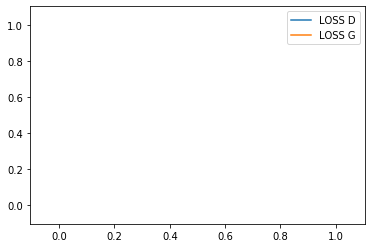

In [22]:
plt.figure()

plt.plot(loss_D, label='LOSS D')
plt.plot(loss_G, label='LOSS G')
plt.legend()
plt.savefig('./CycleGAN_Elevations{}.png'.format(test_number))
plt.show()

In [ ]:
torch.save(generator.state_dict(), './CycleGAN_Elevation_{}_Generator_e200.pt'.format(test_number))
torch.save(discriminator.state_dict(), './CycleGAN_Elevation_{}_Discriminator_e200.pt'.format(test_number))

In [ ]:
# # LOAD MODEL
# discriminator.load_state_dict(torch.load('./CycleGAN_Elevation_{}_Discriminator.pt'.format(test_number)))
# generator.load_state_dict(torch.load('./CycleGAN_Elevation_{}_Generator.pt'.format(test_number)))